In [1]:
import shopify
import requests
import re
import json
import pandas as pd
from pandas.io.json import json_normalize
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from urlparse import urlparse
import datetime as dt
from sklearn_pandas import DataFrameMapper, cross_val_score


%matplotlib inline

In [2]:
products = pd.read_csv('products.csv', index_col=0)

In [3]:
products.head(2)

,date_created,desc,fulfillment,inv_qty,old_inv_qty,price,prod_id,prod_type,title,vendor
0,2016-12-16T09:58:46-08:00,"<meta charset=""utf-8"">The City of Angels is fl...",manual,0,0,18.0,9211737484,Book,36 Hours in Los Angeles and Beyond // Taschen,The Library
1,2016-12-16T09:56:05-08:00,"<meta charset=""utf-8"">\n<p>""New York remains o...",manual,0,0,18.0,9211725708,Book,36 Hours In New York and Beyond // Taschen,The Library


In [4]:
customers = pd.read_csv('customers.csv', index_col=0)

In [5]:
customers.head(2)

,accepts_marketing,cust_id,state,total_orders,total_spent,user_since,zip
0,False,5945331724,MI,1,41.0,False,48092
1,False,5944946572,TN,1,45.0,False,37043


In [6]:
orders = pd.read_csv('orders.csv', index_col=0)

/Users/zober/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,34,64,67,77,113,117) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
orders.head(2)

,billing_address.address1,billing_address.address2,billing_address.city,billing_address.company,billing_address.country,billing_address.country_code,billing_address.first_name,billing_address.last_name,billing_address.latitude,billing_address.longitude,...,test,token,total_discounts,total_line_items_price,total_price,total_price_usd,total_tax,total_weight,updated_at,user_id
0,620 Magnolia Ave.,NaN,Pasadena,Chateau de Pilmer,United States,US,Susie,Pilmer,34.135228,-118.143905,...,False,af8a143ff88c77a90a58b447d4f62429,0.0,89.5,117.93,117.93,7.83,2268,2017-03-21T11:20:07-07:00,NaN
0,2580 Armacost Ave,NaN,Los Angeles,NaN,United States,US,Gina,Binder,34.025735,-118.445775,...,False,00bd07f118aa4dc8b26544e1e88fe6de,0.0,70.0,96.73,96.73,6.13,2268,2017-03-21T11:17:44-07:00,NaN


### Feature Selection

In [22]:
for c in orders.columns:
    print c

billing_address.address1
billing_address.address2
billing_address.city
billing_address.company
billing_address.country
billing_address.country_code
billing_address.first_name
billing_address.last_name
billing_address.latitude
billing_address.longitude
billing_address.name
billing_address.phone
billing_address.province
billing_address.province_code
billing_address.zip
browser_ip
buyer_accepts_marketing
cancel_reason
cancelled_at
cart_token
checkout_id
checkout_token
client_details.accept_language
client_details.browser_height
client_details.browser_ip
client_details.browser_width
client_details.session_hash
client_details.user_agent
closed_at
confirmed
contact_email
created_at
currency
customer.accepts_marketing
customer.created_at
customer.default_address.address1
customer.default_address.address2
customer.default_address.city
customer.default_address.company
customer.default_address.country
customer.default_address.country_code
customer.default_address.country_name
customer.default_ad

(array([ 1603.,  6679.,  1406.,   327.,   119.]),
 array([   0.,   40.,   80.,  120.,  160.,  200.]),
 <a list of 5 Patch objects>)

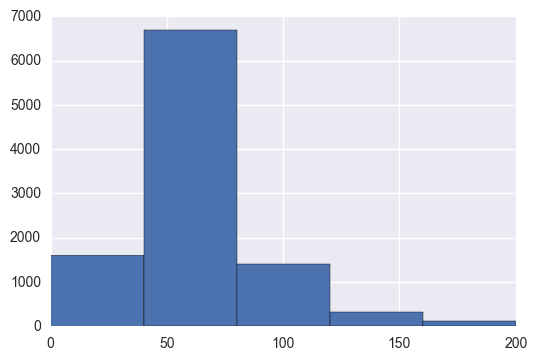

In [8]:
plt.hist(orders['subtotal_price'], bins = 5, range = (0, 200))

In [9]:
#get host name from referring site

def get_host(row):
    if row != np.nan:
        url = urlparse(row)
        host = url.hostname
        if host != None:
            host = host.strip('www.')
            host = host.strip('.com')
            host = host.strip('l.')
            host = host.strip('r.')

            return host
        else:
            return row
    else:
        return row

orders['referring_domain'] = orders['referring_site'].astype('string').apply(get_host)

In [10]:
#extract discount data from discount attribute

def get_dict_value(row, val):
    try:
        if row == "[]":
            return np.nan
        else:
            row = row.strip('[]')
            row_dict = ast.literal_eval(row)
            return row_dict[val]
    except:
        return np.nan

orders['discount_amount'] = orders['discount_codes'].apply(lambda x: get_dict_value(x, val='amount'))
orders['discount_code'] = orders['discount_codes'].apply(lambda x: get_dict_value(x, val='code'))
orders['discount_type'] = orders['discount_codes'].apply(lambda x: get_dict_value(x, val='type'))

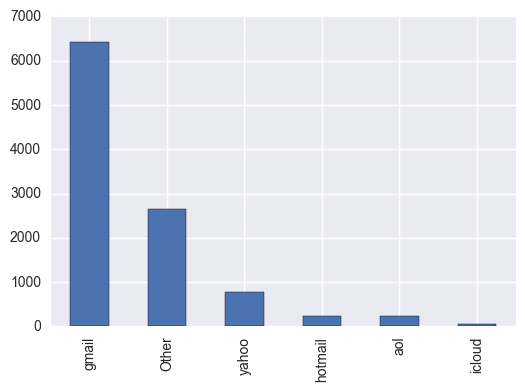

In [11]:
#extract email host from user email

def get_email(row):
    if '@' in row:
        return row.split('@')[1]
    else:
        return np.nan
    
def get_email_host(row):
    if 'gmail' in row.lower():
        return 'gmail'
    elif 'yah' in row.lower():
        return 'yahoo'
    elif 'hotmail' in row.lower():
        return 'hotmail'
    elif 'aol' in row.lower():
        return 'aol'
    elif 'icloud' in row.lower():
        return 'icloud'
    else:
        return 'Other'
        

orders['email_host'] = orders['email'].astype('string').apply(get_email_host)
orders['email_host'].value_counts().plot(kind='bar')

In [12]:
orders['shipping_detail'] = orders['shipping_lines'].apply(lambda x: get_dict_value(x, val='title'))

In [13]:
orders['shipping_detail'].unique()

array([u'Postmates (same-day delivery)',
       u'Standard Shipping (2-6 business days)',
       u'UPS Ground / 2 boxes (2-6 business days)',
       u'UPS Three-Day Select',
       u'UPS Ground / 6 boxes (2-6 business days)',
       u'UPS Next Day Air Early A.M.',
       u'UPS Ground / 12 boxes (2-6 business days)',
       u'UPS Ground / 3 orders (2-6 business days)',
       u'UPS Ground / 7 boxes (2-6 business days)',
       u'UPS Ground / 5 boxes (2-6 business days)', u'UPS Next Day Air',
       u'UPS Second Day Air', u'UPS Ground / 4 boxes (2-6 business days)',
       u'UPS Ground / 8 boxes (2-6 business days)',
       u'Standard Shipping / 2 boxes (2-6 business days)',
       u'UPS Ground / 10 boxes (2-6 business days)',
       u'UPS Ground / 9 boxes (2-6 business days)', u'1 BOXFOX',
       u'USPS - ONE ORDER', u'FedEx - THREE ORDERS', u'USPS - TWO ORDERS',
       u'3 BOXFOX', u'FedEx - FOUR ORDERS', u'4 BOXFOX',
       u'FedEx - SIX ORDERS', u'FIVE BOXES', u'2 BOXFOX', u'SIX BOXE

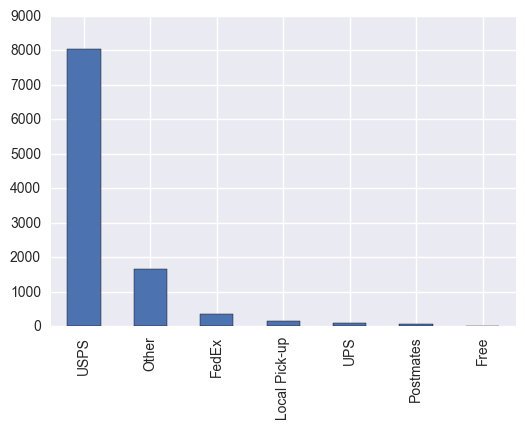

In [14]:
#Extract Shipping Features

def get_ship_meth(row):
    if pd.isnull(row) == True:
        return 'Other'
    if 'ups' in row.lower():
        return 'UPS'
    elif 'fedex' in row.lower():
        return 'FedEx'
    elif 'usps' in row.lower():
        return 'USPS'
    elif 'standard' in row.lower():
        return 'USPS'
    elif 'free' in row.lower():
        return 'Free'
    elif 'local' in row.lower():
        return 'Local Pick-up'
    elif 'postmates' in row.lower():
        return 'Postmates'
    else:
        return 'Other'
    
orders['shipping_meth'] = orders['shipping_detail'].apply(get_ship_meth)
orders['shipping_meth'].value_counts().plot(kind='bar')

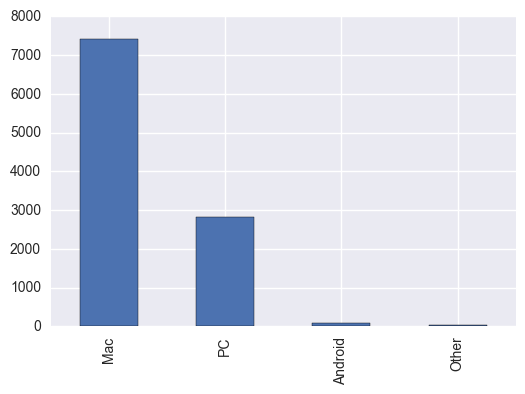

In [15]:
#Extract User Agent Features
#get client details
def get_device(row):
    if pd.isnull(row) == True:
        return 'Other'
    elif 'mac' in row.lower():
        return 'Mac'
    elif 'windows' in row.lower():
        return 'PC'
    elif 'iphone' in row.lower():
        return 'iPhone'
    elif 'ipad' in row.lower():
        return 'iPad'
    elif 'android' in row.lower():
        return 'Android'
    else:
        return 'Other'


orders['device'] = orders['client_details.user_agent'].apply(get_device)
orders['device'].value_counts().plot(kind='bar')

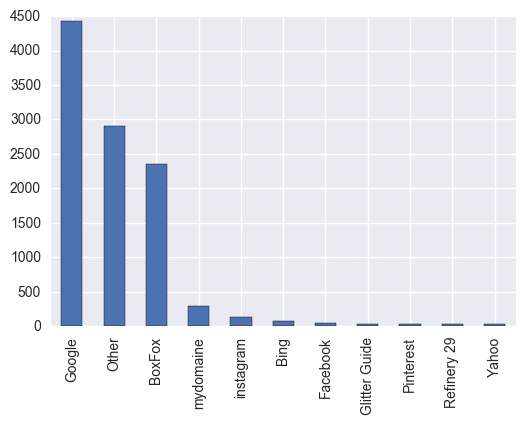

In [16]:
def get_refer(row):
    if pd.isnull(row) == True:
        return 'Other'
    elif 'google' in row.lower():
        return 'Google'
    elif 'theglitterguide' in row.lower():
        return 'Glitter Guide'
    elif 'insta' in row.lower():
        return 'instagram'
    elif 'mydomaine' in row.lower():
        return 'mydomaine'
    elif 'boxfox' in row.lower():
        return 'BoxFox'
    elif 'refinery' in row.lower():
        return 'Refinery 29'
    elif 'pinterest' in row.lower():
        return 'Pinterest'
    elif 'facebook' in row.lower():
        return 'Facebook'
    elif 'yahoo' in row.lower():
        return 'Yahoo'
    elif 'bing' in row.lower():
        return 'Bing'
    else:
        return 'Other'
    
orders['referring_domain'] = orders['referring_site'].apply(get_refer)
orders['referring_domain'].value_counts().plot(kind="bar")

In [208]:
orders['days_till_signup'] = (pd.to_datetime(orders['customer.created_at']) - pd.datetime(2014, 11, 01)).dt.days

In [213]:
orders['seconds_to_purchase'] = (pd.to_datetime(orders['processed_at']) - pd.to_datetime(orders['customer.created_at'])).dt.seconds

In [216]:
orders['month_of_purchase'] = pd.to_datetime(orders['processed_at']).dt.month

In [217]:
orders = orders.fillna({'customer.id': 0,
                        'payment_details.credit_card_company': 'None',
                        'discount_type': 'None',
                        'referring_domain': 'None',
                        'days_till_signup': 0,
                        'seconds_to_purchase': 0,
                        'month_of_purchase': 0
               })

### Create Target

In [218]:
orders['customer.id'] = orders['customer.id'].astype('int')
orders['order_date'] = pd.to_datetime(orders['created_at'])
target_df = orders.groupby(['customer.id']).agg({'order_date': ['min', 'count']}).reset_index()

target_df['target'] = target_df['order_date']['count'] > 1
target_df.columns = target_df.columns.get_level_values(1)
target_df['customer.id'] = target_df.iloc[:,0]
target_df['target'] = target_df.iloc[:,3]
target_df = target_df[['customer.id', 'min', 'count', 'target']]
target_df.head()

,customer.id,min,count,target
0,0,2016-11-15 22:47:56,3,True
1,253362255,2015-06-23 04:23:57,18,True
2,322055183,2016-03-17 23:37:12,1,False
3,322057979,2015-08-24 06:06:29,2,True
4,322058215,2017-02-01 16:45:21,4,True


In [220]:
model_data = pd.merge(orders, target_df, left_on=['customer.id', 'order_date'], right_on=['customer.id','min'])

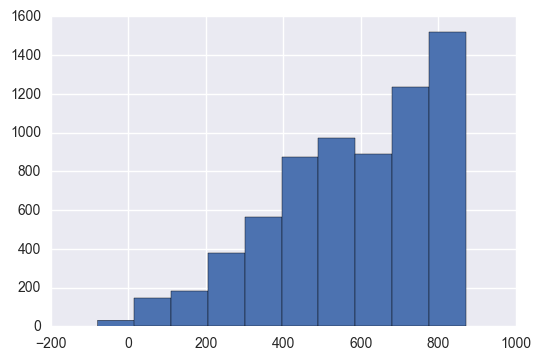

In [225]:
model_data.days_till_signup.hist()

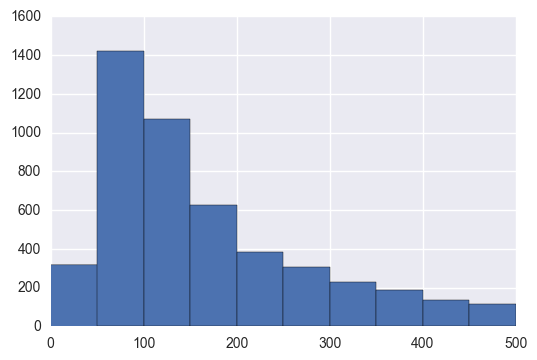

In [237]:
model_data.seconds_to_purchase.hist(range=(0,500))

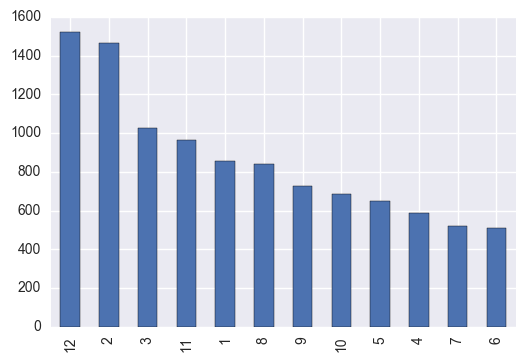

In [229]:
orders.month_of_purchase.value_counts().plot(kind='bar')

In [231]:
features = model_data[['buyer_accepts_marketing', 'payment_details.credit_card_company', 'referring_domain',
                       'total_price', 'total_weight', 'discount_type', 'device', 'shipping_meth',
                      'seconds_to_purchase', 'month_of_purchase', 'days_till_signup']]

target = model_data['target']

In [233]:
target.value_counts()

False    4918
True     1874
Name: target, dtype: int64

### Pre-processing

In [234]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

In [235]:
features.columns

Index([u'buyer_accepts_marketing', u'payment_details.credit_card_company',
       u'referring_domain', u'total_price', u'total_weight', u'discount_type',
       u'device', u'shipping_meth', u'seconds_to_purchase',
       u'month_of_purchase', u'days_till_signup'],
      dtype='object')

In [25]:
mapper = DataFrameMapper([
        ('payment_details.credit_card_company', LabelBinarizer()),
        ('buyer_accepts_marketing', LabelBinarizer()),
        ('referring_domain', LabelBinarizer()),
        ('discount_type', LabelBinarizer()),
        ('device', LabelBinarizer()),
        ('shipping_meth', LabelBinarizer()),
        ('days_user', StandardScaler()),
        ('total_price', StandardScaler()),
        ('total_weight', StandardScaler()),
        ('seconds_to_purchase', StandardScaler()),
        ('month_of_')
    ])

In [28]:
mapper2 = DataFrameMapper([
        ('payment_details.credit_card_company', LabelBinarizer()),
        ('buyer_accepts_marketing', LabelBinarizer()),
        ('referring_domain', LabelBinarizer()),
        ('discount_type', LabelBinarizer()),
        ('device', LabelBinarizer()),
        ('shipping_meth', LabelBinarizer()),
        ('days_user', StandardScaler()),
        ('total_price', None),
        ('total_weight', None)
    ], df_out=True)

In [29]:
mapper_df = mapper2.fit_transform(features)
mapper_df.head()

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueE

,payment_details.credit_card_company_American Express,payment_details.credit_card_company_Discover,payment_details.credit_card_company_Mastercard,payment_details.credit_card_company_None,payment_details.credit_card_company_Visa,buyer_accepts_marketing,referring_domain_Bing,referring_domain_BoxFox,referring_domain_Facebook,referring_domain_Glitter Guide,...,shipping_meth_FedEx,shipping_meth_Free,shipping_meth_Local Pick-up,shipping_meth_Other,shipping_meth_Postmates,shipping_meth_UPS,shipping_meth_USPS,days_user,total_price,total_weight
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.375446,117.93,2268.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.375446,117.93,2268.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.375446,96.73,2268.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.375446,96.73,2268.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.375446,76.50,2268.0


### Build out Model Pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split

In [31]:
pipe = Pipeline([
    ('featurize', mapper),
    ('gb', GradientBoostingClassifier())]
    )

In [32]:
X_train, X_Holdout, y_train, y_Holdout = train_test_split(features, target, test_size = .3)

In [33]:
pipe.fit(X_train, y=y_train)

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueE

Pipeline(steps=[('featurize', DataFrameMapper(default=False, df_out=False,
        features=[('payment_details.credit_card_company', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('buyer_accepts_marketing', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('referring_domain',...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [120]:
zip(mapper_df.columns, pipe.steps[-1][1].feature_importances_)

[('payment_details.credit_card_company_American Express',
  0.017833300278671783),
 ('payment_details.credit_card_company_Discover', 0.0082381136002368776),
 ('payment_details.credit_card_company_Mastercard', 0.0),
 ('payment_details.credit_card_company_None', 0.005900267904757955),
 ('payment_details.credit_card_company_Visa', 0.011097314101788189),
 ('buyer_accepts_marketing', 0.028110416750908186),
 ('referring_domain_Bing', 0.0021548144826678988),
 ('referring_domain_BoxFox', 0.020418275756081176),
 ('referring_domain_Facebook', 0.0095319749930972975),
 ('referring_domain_Glitter Guide', 0.0018629707520125556),
 ('referring_domain_Google', 0.022914101673837707),
 ('referring_domain_Other', 0.0022169304282874656),
 ('referring_domain_Pinterest', 0.0),
 ('referring_domain_Refinery 29', 0.0068805515954424301),
 ('referring_domain_Yahoo', 0.0),
 ('referring_domain_instagram', 0.010870715968537019),
 ('referring_domain_mydomaine', 0.0080648601294177318),
 ('discount_type_', 0.0008066095

In [35]:
pred_prob = pipe.predict_proba(X_Holdout)

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [36]:
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, precision_score, confusion_matrix

In [37]:
prec, recall, thresh = precision_recall_curve(y_Holdout, pred_prob[:,1])

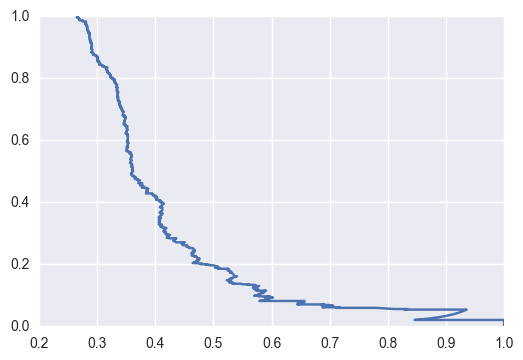

In [38]:
plt.plot(prec[0:-1], recall[0:-1])

In [44]:
pred = np.greater( pred_prob[:,1],.6)

print(recall_score(y_Holdout, pred))
print(precision_score(y_Holdout, pred))
print(accuracy_score(y_Holdout, pred))

0.0612244897959
0.702127659574
0.744847890088


In [45]:
pred_o =1-pred

print(recall_score(1-y_Holdout, pred_o))
print(precision_score(1-y_Holdout, pred_o))

0.990660440294
0.745856353591


In [46]:
confusion_matrix(y_Holdout, pred)

array([[1485,   14],
       [ 506,   33]])

### Cross Val Score to Check Balance of Target

In [47]:
from sklearn.cross_validation import cross_val_score

In [47]:
cv_score = cross_val_score(pipe ,X_train, y_train, cv=5)

/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/zober/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueE

In [48]:
print(str(cv_score.mean()) + ' ' + str(cv_score.std()))

0.741693393346 0.00560487092356


### Get Product Data

- 'requires_shipping',
- 'variant_id',
- 'id',
- 'product_exists',
- 'sku',
- 'title',
- 'origin_location',
- 'fulfillment_service',
- 'total_discount',
- 'variant_title',
- 'vendor',
- 'tax_lines',
- 'price',
- 'taxable',
- 'properties',
- 'name',
- 'fulfillable_quantity',
- 'grams',
- 'gift_card',
- 'fulfillment_status',
- 'product_id',
- 'variant_inventory_management',
- 'destination_location',
- 'quantity'

In [48]:
prod = orders['fulfillments']

In [122]:
order_ids = list(orders['id'])

In [123]:
def get_message(prop):
    #Gets message on card in box
    for item in prop:
        if item['name'] == 'Message on Card':
            return item['value']
        else:
            continue

order_id = []
prod_title = []
prod_id = []
name = []
message = []

for id_ in order_ids:
    fulfillments = orders[orders['id']==id_]['fulfillments']
    for f in fulfillments:
        f_dict = ast.literal_eval(f)
        for i in f_dict:
            item = i['line_items']
            for x in item:
                order_id.append(id_)
                prod_title.append(x['title'])
                prod_id.append(x['product_id'])
                name.append(x['name'])
                message.append(get_message(x['properties']))
        

In [124]:
orders_products = pd.DataFrame({'order_id': order_id,
             'prod_title': prod_title,
             'prod_id': prod_id,
             'name': name,
             'message': message})

orders_products.drop_duplicates(inplace=True)

In [54]:
from bs4 import BeautifulSoup
import re

In [125]:
products['desc'].fillna('None', inplace = True)

def get_parent(x):
    if x is None:
        return None
    else:
        spl = x.split('/')[0]
        return spl.split(u'×')[1]

def get_items_custom(row):
    soup = BeautifulSoup(row)
    items = [p.text for p in soup.findAll('p')[1:]]
    return ', '.join([get_parent(i) for i in items])

def get_items_curated(row):
    if 'includes:' in row.lower():
        try:
            soup = BeautifulSoup(row)
            items = str(soup.findAll('p')[1]).split('<br/>')[1:]
            return ', '.join([get_parent(i) for i in items])
        except:
            return None
    else:
        return None

custom = products[products['title'] == 'Custom BOXFOX']
curated = products[products['title'] != 'Custom BOXFOX']

custom['items'] = custom['desc'].apply(get_items_custom)
curated['items'] = curated['desc'].apply(get_items_curated)

/Users/zober/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zober/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [126]:
products = pd.concat([curated, custom])

In [127]:
products.head()

,date_created,desc,fulfillment,inv_qty,old_inv_qty,price,prod_id,prod_type,title,vendor,items
0,2016-12-16T09:58:46-08:00,"<meta charset=""utf-8"">The City of Angels is fl...",manual,0,0,18.0,9211737484,Book,36 Hours in Los Angeles and Beyond // Taschen,The Library,None
1,2016-12-16T09:56:05-08:00,"<meta charset=""utf-8"">\n<p>""New York remains o...",manual,0,0,18.0,9211725708,Book,36 Hours In New York and Beyond // Taschen,The Library,None
2,2017-01-24T16:28:51-08:00,"<meta charset=""utf-8"">\n<p>Dona Chai 8oz mini ...",manual,18,18,8.0,9498705420,Chai Concentrate,8oz Chai Concentrate,Dona Chai,None
3,2016-07-28T15:58:49-07:00,"<p>A hand wrapped, custom built gift box that ...",manual,1,1,27.0,7810617606,Custom Box,A SIMPLE THANK YOU,BOXFOX,None
4,2015-05-18T18:57:12-07:00,"<meta charset=""utf-8"">\n<p>The Social Type's ""...",manual,1,1,10.0,565214915,Matchbox,Ahoy Matchbox,The Social Type,None


In [128]:
orders_products['prod_id'].fillna(0, inplace=True)
orders_products['prod_id'] = orders_products['prod_id'].apply(int)

In [ ]:
cols_to_use = products.columns.difference(orders_products.columns).tolist()
cols_to_use.append('prod_id')
cols_to_use2 = orders.columns.difference(orders_products_products.columns).tolist()

In [149]:
orders_products_products = pd.merge(products[cols_to_use], orders_products, on ='prod_id')
orders_products_final = pd.merge(orders[cols_to_use2], orders_products_products, left_on='id', right_on='order_id')

orders_products.drop_duplicates(inplace=True)

In [150]:
orders_products_final.to_csv('orders_products.csv', encoding='UTF8')

In [154]:
API_KEY = "f4678273f6be2f7ce7d4e67b8173ce5b"
PASSWORD = "471d7b85e1ef2153d0892f934340fb6e"
shop_url = "https://%s:%s@boxfox.myshopify.com/admin/" % (API_KEY, PASSWORD)
shopify.ShopifyResource.set_site(shop_url)

In [155]:
shopify.Customer.get('5944578828')

{u'accepts_marketing': True,
 u'addresses': [],
 u'created_at': u'2017-03-20T14:40:55-07:00',
 u'email': u'leahaber@umich.edu',
 u'first_name': u'Lauren',
 u'id': 5944578828,
 u'last_name': u'Haber',
 u'last_order_id': None,
 u'last_order_name': None,
 u'multipass_identifier': None,
 u'note': None,
 u'orders_count': 0,
 u'phone': None,
 u'state': u'enabled',
 u'tags': u'',
 u'tax_exempt': False,
 u'total_spent': u'0.00',
 u'updated_at': u'2017-03-20T14:40:55-07:00',
 u'verified_email': True}

In [184]:
orders[orders['customer.id']==5954703820][['customer.created_at','processed_at']]

,customer.created_at,processed_at
0,2017-03-21T10:48:09-07:00,2017-03-21T10:53:59-07:00
0,2017-03-21T10:48:09-07:00,2017-03-21T10:53:59-07:00
